In [1]:
import numpy as np

# Haunted Mansion

Welcome to the haunted mansion, a 3 dimensional array for an agent to learn to navigate. The agent will start out in position (0,0,0) and it will try to exit at point (size,size,size). I will start with a relatively small size and adjust it if needed.

### The agent will encounter a few things throughout its journey through the haunted mansion. 
- It will encounter monsters sporadically
    - There will be "hot spots", maybe 3x3x3 areas where monsters are likely to spawn, and in the center of themis lots of treasure. 
    
- It will encounter treasure throughout its adventure
    - The treasure will be the *value* metric of the agent. The immediate reward will be the steps that it takes. 
    

### Two policies
1. We'll try to design a policy where the agent wants to get *out* of the haunted mansion as quickly as it can. 

2. We'll also try a "hero" policy where it collects as much treasure as it can and gains strength (through slaying monsters) 

### Strength
The agent will have a strength that determines whether it will die or win against a given monster. The monsters will spawn probabilistically in a given "hot spot" and they will have strengths as well. If the agent wins (ie. agent strength > monster strength), it gains strength. If they are equally matched, it is a coin flip. 

### Treasure 
Treasure will be the value function of the environment. There will be more treasure available inside of the monster zones. 

In [2]:
# Let's first set up the environment and the agent

# importing scipy.stats for normal distribution for monster spawning probabilities
import scipy.stats

tre = 0
mon = 1

class Environment: 
    def __init__(self, size, hotspots=[(3,3,3,3)]):
        self.size = size
        self.hotspot_prob_cache3x3 = self.gen_hotspot_prob_matrix(3)
        self.hotspot_prob_cache5x5 = self.gen_hotspot_prob_matrix(5)
        self.hotspots = hotspots
        self.map = self.generate_map(size, hotspots)
        
    def generate_map(self, map_size, hotspots):
        env = np.empty(shape=(map_size, map_size, map_size, 2))
        
        for i in range(map_size):
            for j in range(map_size):
                for k in range(map_size):
                    treasure = 0
                    monster = 0
                    env[i,j,k] = [treasure, monster]
                    
        for (x, y, z, s) in hotspots:
            r = s // 2
            env[x-r:x+r+1, y-r:y+r+1, z-r:z+r+1] = self.populate_hotspot((x, y, z), s)
        
        return env
            
            
    def populate_hotspot(self, loc, hotspot_size):
        r = hotspot_size // 2
        x, y, z = loc
        
        hotspot = np.empty(shape=(hotspot_size, hotspot_size, hotspot_size, 2))
        
        for i in range(hotspot_size):
            for j in range(hotspot_size):
                for k in range(hotspot_size):
                    # treasure is multiplied by the probability of a monster
                    if hotspot_size == 3:
                        treasure = self.hotspot_prob_cache3x3[i,j,k] * 50
                    elif hotspot_size == 5:
                        treasure = self.hotspot_prob_cache5x5[i,j,k] * 50
                    monster = np.random.randint(8)+1       # random strength 1 to 8
                    hotspot[i,j,k] = [treasure, monster]
        
        return hotspot
    
    
    def regenerate_hotspots(self):
        for (x, y, z, s) in self.hotspots:
            r = s // 2
            self.map[x-r:x+r+1, y-r:y+r+1, z-r:z+r+1] = self.populate_hotspot((x, y, z), s)
            
        
        
    
    # the distance from the center of the hotspot determines
    # how likely a monster is to spawn there - there is always
    # a monster in the center
    def gen_hotspot_prob_matrix(self, size):
        
        arr = np.zeros((size,size,size))
        mid = (size//2, size//2, size//2)
        xh, yh, zh = mid
        
        # generate probabilities at given relative locations
        for i in range(size):
            for j in range(size):
                for k in range(size):
                    dist = np.sqrt((i-xh)**2 + (j-yh)**2 + (k-zh)**2)
                    gen_prob = scipy.stats.norm(0, size/2).cdf(-dist)
                    arr[i,j,k] = gen_prob
        
        # always a monster in the center!
        arr[mid] = 1
                    
        return arr
        


In [3]:
env = Environment(6, hotspots=[(3,3,3,3)])

# here's the probability of a monster spawning in a given 3x3x3 hotspot
# note there will always be a monster in the middle of the hotspot
# (this is where the most treasure is!)
print(env.hotspot_prob_cache3x3)

[[[0.12410654 0.17288929 0.12410654]
  [0.17288929 0.25249254 0.17288929]
  [0.12410654 0.17288929 0.12410654]]

 [[0.17288929 0.25249254 0.17288929]
  [0.25249254 1.         0.25249254]
  [0.17288929 0.25249254 0.17288929]]

 [[0.12410654 0.17288929 0.12410654]
  [0.17288929 0.25249254 0.17288929]
  [0.12410654 0.17288929 0.12410654]]]


In [4]:
# and here we can see the "hot spot" on a small map
# the numbers are the strengths of the monsters in that area
print(env.map[:,:,:, 1])

[[[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 8. 5. 1. 0.]
  [0. 0. 2. 3. 7. 0.]
  [0. 0. 5. 6. 6. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 4. 4. 5. 0.]
  [0. 0. 8. 8. 2. 0.]
  [0. 0. 3. 8. 1. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 7. 3. 4. 0.]
  [0. 0. 5. 4. 3. 0.]
  [0. 0. 2. 6. 4. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]]


## Agent
Now we have to design an agent.

An agent has actions that respond to the environment. The actions here will be up, down, left, right, forward, and backward. This first Agent we're going to try to get him to simply get to the exit as fast as possible. This policy should be relatively easy to implement - we're going to just take the distance formula from the position the agent is at, and if it steps in the direction of the exit, we reward it

What will be interesting is when it encounters a hotspot and gets negative reward for dying, will it tend to avoid the area? 

### Bellman Equation
The Bellman equation, used to update the policies at each step:



In [5]:
class Agent:
    def __init__(self, environment):
        self.actions = [0,1,2,3,4,5]
        self.strength = 2
        self.treasure = 0.0
        self.environment = environment
        self.env_size = environment.size
        self.final_pos = (self.environment.size-1, self.environment.size-1, self.environment.size-1)
        self.q_table = self.make_q_table(environment)
    
    def act(self, position):
        x, y, z = position
        
        # might have to change this to pick randomly
        action = self.choose_action(position)
        
        # update position
        if action == 0: # up
            new_pos = (x,y,z+1)
        elif action == 1: # down
            new_pos = (x,y,z-1)
        elif action == 2: # left
            new_pos = (x-1,y,z)
        elif action == 3: # right
            new_pos = (x+1,y,z)
        elif action == 4: # forward
            new_pos = (x,y+1,z)
        elif action == 5: # backward
            new_pos = (x,y-1,z)
        
        new_x, new_y, new_z = new_pos
        
        # check if agent went off the map
        if new_x < 0 or new_y < 0 or new_z < 0 or new_x >= self.env_size or new_y >= self.env_size or new_z >= self.env_size:
            reward = -5
            new_pos = position
            return action, new_pos, reward, False
        
        reward = 1
        
        # check for monsters and simulate interaction 
        monster = self.environment.map[new_pos][1]
        if monster:
            if self.strength > monster or (self.strength == monster and np.random.uniform() <= 0.5):
                self.treasure += self.environment.map[new_pos][0]
                self.strength += 1
            else:
                reward = -5
                return action, new_pos, reward, True
        
        return action, new_pos, reward, False
            
        
        # Function for choosing the action for the agent
    def choose_action(self, position):

        # Selection of the action - 90 % according to the epsilon == 0.9
        # Choosing the best action
        if np.random.uniform() < 0.9 and not (np.argmin(self.q_table[position]) == np.argmax(self.q_table[position])):
            state_action = self.q_table[position]
            action = np.argmax(state_action)
        else:
            # Choosing random action - left 10 % for choosing randomly
            action = np.random.choice(self.actions)
        
        return action

    
    
    def learn(self, episodes=1000, learning_rate=0.9):
        
        self.learning_rate = learning_rate
        
        # reward decay
        self.gamma = 0.1
        
        # reset q table
        self.q_table = self.make_q_table(self.environment)
        
        for e in range(episodes):
            position = (0,0,0)
            self.strength = 0
            if e % 100 == 0:
                print('episode {}'.format(e))
            while position != self.final_pos:
                action, new_pos, reward, dead = self.act(position)
                if new_pos == self.final_pos:
                    self.q_table[position][action] += 50
                else:
                    self.q_table[position][action] += learning_rate * ((reward + self.gamma * max(self.q_table[new_pos]) - self.q_table[position][action]))
                # print(learning_rate, reward, self.gamma, max(self.q_table[new_pos]))
                if dead:
                    position = (0,0,0)
                    break
                
                position = new_pos
                
    def run(self):
        xy_run = np.zeros((self.env_size, self.env_size))
        xz_run = np.zeros((self.env_size, self.env_size))
        yz_run = np.zeros((self.env_size, self.env_size))
        
        xy_run[0,0] = 1
        xz_run[0,0] = 1
        yz_run[0,0] = 1
        
        position = (0,0,0)

        while position != self.final_pos:
            action, new_pos, reward, dead = self.act(position)
            # self.q_table[position][action] += reward
            
            x, y, z = new_pos
            xy_run[x,y] = 1
            xz_run[x,z] = 1
            yz_run[y,z] = 1

            if dead:
                position = (0,0,0)
                break
                
            position = new_pos
        
        return xy_run, xz_run, yz_run
            
    
    # the q table is a dictionary containing the reward at each 
    # position in the environment
    def make_q_table(self, environment):
        
        q_table = dict()
        width, height, depth, size = environment.map.shape
        
        for i in range(width):
            for j in range(height):
                for k in range(depth):
                    # index:action
                    # 0:up, 1:down, 2:left, 3:right, 4:fwd, 5:bkwd
                    q_table[(i, j, k)] = [0,0,0,0,0,0]
        
        return q_table
        

In [6]:
learner6x6 = Agent(env)
learner6x6.learn()

episode 0
episode 100
episode 200
episode 300
episode 400
episode 500
episode 600
episode 700
episode 800
episode 900


In [7]:
print(learner6x6.q_table)

{(0, 0, 0): [1.1111111114911687, -4.888888888852876, -4.88888888885404, 1.111111110992801, 1.1111111114655698, -4.888888888855207], (0, 0, 1): [1.111111111145298, 1.1111111111485183, -4.888888888531959, 1.1111111111450027, 1.1111111149168595, -4.8888888885513495], (0, 0, 2): [0, 1.1111111114540295, -4.400000000981848, 0, 1.0000000002996476, 0], (0, 0, 3): [0.9, 1.09989, 0, 1.1111111111111112, 1.1078857751751001, -4.401436851000001], (0, 0, 4): [1.1111099504801822, 0, 0, 0, 0, -4.4190000000000005], (0, 0, 5): [-4.5, 1.1111077107547997, 0, 0.9, 0.9, 0], (0, 1, 0): [1.1111111148086166, -4.884999999745851, 0, 0, 1.00000000059506, 0], (0, 1, 1): [1.1111111114506524, 1.1111111114752377, -4.888888885109923, 1.1111111114571046, 1.1111111492040877, 1.111111111479972], (0, 1, 2): [0, 1.111111114660853, 0, 0, 0, 0], (0, 1, 3): [0, 0, 0, 0, 0, 1.110998563149], (0, 1, 4): [0, 0, 0, 0, 0, 0.9970460999999999], (0, 1, 5): [0, 0.9, 0, 0, 0, 0], (0, 2, 0): [1.1111111483339784, -4.88884, -4.840001, 1.11,

Here's a pseudo visual for what a single run thru the haunted mansion looks like - think of it like a 2d x-ray on each pair of axes.

It looks like the agent is definitely avoiding the monster hot spot

In [8]:
xy, xz, yz = learner6x6.run()
print(xy, '\n\n', xz, '\n\n', yz)

[[1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 1. 1.]] 

 [[1. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1.]] 

 [[1. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0.]
 [0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 1. 1. 1.]]


In [355]:
env10x10 = Environment(size=10, hotspots=[(2,2,2,3), (4,3,5,3)])
learner10x10 = Agent(env10x10)

learner10x10.learn()

episode 0
episode 100
episode 200
episode 300
episode 400
episode 500
episode 600
episode 700
episode 800
episode 900


In [356]:
xy, xz, yz = learner10x10.run()

xy, xz, yz = learner10x10.run()
print(learner10x10.treasure)
print(xy, '\n\n', xz, '\n\n', yz)

0.0
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]] 

 [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]] 

 [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.

#### Wow
I'm amazed at how quickly this thing can learn. It seems that once it finds a correct path, the training speeds up significantly because each run is straight to the exit.

### A treasure-hunter agent
This should be straightforward. The strength system works like this: monsters have strength between 1 and 8. The agent starts at strength 3, and gains 1 strength for every monster it defeats (and also it gets rewarded with treasure)

Should be straightforward to implement; the Agent class stays mostly the same, just the rewards for certain interactions update. 

### Bellman Equation
This is used to reward/punish the agent. The expected value can be positive (positive reinforcement!) or negative (negative reinforcement!) For our treasure hunter agent, we're rewarding the agent for getting to the exit and for defeating monsters and collecting treasure. We're punishing for actions taken to leave the environment, and also if the agent dies fighting a monster. So we need to balance the cost/benefit for encountering a monster so it knows to take the risk. 

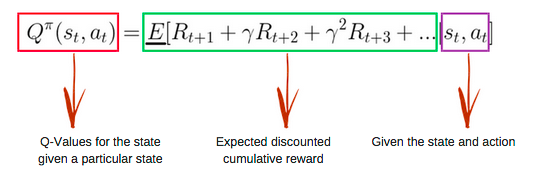

In [9]:
class TreasureHunter:
    def __init__(self, environment):
        self.actions = [0,1,2,3,4,5]
        self.strength = 4
        self.treasure = 0.0
        self.environment = environment
        self.env_size = environment.size
        self.final_pos = (self.environment.size-1, self.environment.size-1, self.environment.size-1)
        self.q_table = self.make_q_table(environment)
        
        # treasure hunter will encounter monsters
        self.monster_encounters = 0
    
    def act(self, position):
        x, y, z = position
        
        # might have to change this to pick randomly
        action = self.choose_action(position)
        
        # update position
        if action == 0: # up
            new_pos = (x,y,z+1)
        elif action == 1: # down
            new_pos = (x,y,z-1)
        elif action == 2: # left
            new_pos = (x-1,y,z)
        elif action == 3: # right
            new_pos = (x+1,y,z)
        elif action == 4: # forward
            new_pos = (x,y+1,z)
        elif action == 5: # backward
            new_pos = (x,y-1,z)
        
        new_x, new_y, new_z = new_pos
        
        # check if agent went off the map
        if new_x < 0 or new_y < 0 or new_z < 0 or new_x >= self.env_size or new_y >= self.env_size or new_z >= self.env_size:
            reward = -5
            new_pos = position
            return action, new_pos, reward, False
        
        reward = 1
        
        # check for monsters and simulate interaction 
        monster = self.environment.map[new_pos][1]
        if monster:
            self.monster_encounters += 1
            if self.strength > monster or (self.strength == monster and np.random.uniform() <= 0.5):
                reward = 20 * self.environment.map[new_pos][0]
                self.treasure += reward
                self.strength += 1
                
                # clear out treasure and monster
                self.environment.map[new_pos] = [0,0]
                
                return action, new_pos, reward, False
            else:
                reward = -1
                return action, new_pos, reward, True
        
        return action, new_pos, reward, False
            
        
        # Function for choosing the action for the agent
    def choose_action(self, position):

        # Selection of the action - 90 % according to the epsilon == 0.9
        # Choosing the best action
        if np.random.uniform() < 0.9 and not (np.argmin(self.q_table[position]) == np.argmax(self.q_table[position])):
            state_action = self.q_table[position]
            action = np.argmax(state_action)
        else:
            # Choosing random action - left 10 % for choosing randomly
            action = np.random.choice(self.actions)
        
        return action

    
    
    def learn(self, episodes=1000, learning_rate=0.9):
        
        self.learning_rate = learning_rate
        
        # reward decay
        self.gamma = 0.1
        
        # reset q table
        self.q_table = self.make_q_table(self.environment)
        
        for e in range(episodes):
            position = (0,0,0)
            self.strength = 6
            self.treasure = 0
            self.monster_encounters = 0
            
            # reset treasure and generate new monsters
            self.environment.regenerate_hotspots()
            
            if e % 100 == 0:
                print('episode {}'.format(e))
            while position != self.final_pos:
                action, new_pos, reward, dead = self.act(position)
                if new_pos == self.final_pos:
                    #### 
                    # Treasure hunter values exiting less
                    ####
                    self.q_table[position][action] += 2
                else:
                    ######
                    # Bellman Equation! 
                    ######
                    self.q_table[position][action] += learning_rate * ((reward + self.gamma * max(self.q_table[new_pos]) - self.q_table[position][action]))
                # print(learning_rate, reward, self.gamma, max(self.q_table[new_pos]))
                if dead:
                    position = (0,0,0)
                    break
                
                position = new_pos
                
    def run(self):
        xy_run = np.zeros((self.env_size, self.env_size))
        xz_run = np.zeros((self.env_size, self.env_size))
        yz_run = np.zeros((self.env_size, self.env_size))
        
        xy_run[0,0] = 1
        xz_run[0,0] = 1
        yz_run[0,0] = 1
        
        position = (0,0,0)
        self.strength = 6
        self.treasure = 0
        self.monster_encounters = 0

        while position != self.final_pos:
            action, new_pos, reward, dead = self.act(position)
            # self.q_table[position][action] += reward
            
            x, y, z = new_pos
            xy_run[x,y] = 1
            xz_run[x,z] = 1
            yz_run[y,z] = 1

            if dead:
                position = (0,0,0)
                break
                
            position = new_pos
        
        return xy_run, xz_run, yz_run
            
    
    # the q table is a dictionary containing the reward at each 
    # position in the environment
    def make_q_table(self, environment):
        
        q_table = dict()
        width, height, depth, size = environment.map.shape
        
        for i in range(width):
            for j in range(height):
                for k in range(depth):
                    # index:action
                    # 0:up, 1:down, 2:left, 3:right, 4:fwd, 5:bkwd
                    q_table[(i, j, k)] = [0,0,0,0,0,0]
        
        return q_table

In [447]:
env9 = Environment(size=9, hotspots=[(3,4,5,3), (1,4,1,3), (2,6,6,3)])

th9 = TreasureHunter(env9)
th9.learn()

episode 0
episode 100
episode 200
episode 300
episode 400
episode 500
episode 600
episode 700
episode 800
episode 900


#### A bad run
Monster hunting is treacherous

In [452]:
xy, xz, yz = th9.run()

print('monter encounters: ', th9.monster_encounters)
print(th9.treasure)
print(xy, '\n\n', xz, '\n\n', yz)

monter encounters:  1
0
[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]] 

 [[1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]] 

 [[1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


#### A good run

Here's a good run, the treasure hunter was able to gain its strength and venture to the monsters' lairs and defeat them and gather some treasure.

In [453]:
xy, xz, yz = th9.run()

print('monter encounters: ', th9.monster_encounters)
print(th9.treasure)
print(xy, '\n\n', xz, '\n\n', yz)

monter encounters:  26
5586.758516705193
[[1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 1. 1. 1. 0.]
 [1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]] 

 [[1. 1. 1. 0. 0. 1. 1. 0. 0.]
 [0. 0. 1. 0. 1. 1. 1. 1. 0.]
 [0. 0. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 1. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 0. 1. 1. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]] 

 [[1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 0. 0. 0.]
 [0. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 1. 0.]
 [0. 0. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]]


In [459]:
env20 = Environment(size=20, hotspots=[(3,4,5,3), (2,4,2,3), (2,6,6,3), (10,12,4,5), (5,16,9,3)])
agent20 = TreasureHunter(env20)

In [460]:
agent20.learn(episodes=2500)

episode 0
episode 100
episode 200
episode 300
episode 400
episode 500
episode 600
episode 700
episode 800
episode 900
episode 1000
episode 1100
episode 1200
episode 1300
episode 1400
episode 1500
episode 1600
episode 1700
episode 1800
episode 1900
episode 2000
episode 2100
episode 2200
episode 2300
episode 2400


In [466]:
xy, xz, yz = agent20.run()

print('monter encounters: ', agent20.monster_encounters)
print(agent20.treasure)
print(xy, '\n\n', xz, '\n\n', yz)

monter encounters:  227
44335.55296750015
[[1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0.

### Nice! 
There were 233 monsters possible, so that run got close to killing them all and collecting *all* the treasure. This monster hunter is pretty good!